In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
        
import torch 
import torch.nn as nn
import torch.nn.functional as F


In [4]:
memory_size = 10000
pretrain_length = 100
batch_size = 100
action_size = 2
state_size = 4
n_episodes = 400

In [5]:
from collections import deque

class Memory() :
    def __init__ (self, max_size = 1000):
        self.buffer = deque(maxlen = max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size = batch_size, replace = False)
        return [self.buffer[ii] for ii in idx]

In [6]:
import gym
# Create the Cart - Pole game environment
env = gym.make('CartPole-v0')


In [7]:

# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size = memory_size)

# Make a bunch of random actions and store the experiences
for _ in range (pretrain_length):
    
    # Do a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
  
    if done:
        # Simulation fails, so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state      

In [8]:
class feed_foward_net(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim=64, lr=0.0001):
        super(feed_foward_net, self).__init__()
        #Input_dim should be input shape
        #output_dim should be action space

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

def epsilon(t, emin = 0.005, emax = 1, alpha = 0.01):
    return emin+(emax-emin)*np.exp(-alpha*t)

def epsilon_greddy_policy(epsilon, net, env, state):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            q_values = net(torch.Tensor(state))
            action = torch.argmax(q_values).item()

    return action
            
#This is made using https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
#But we have a different values in memory
def optimize_model(memory, gamma, batch_size, opt, criterion, policy_net, target_net):
    mini_batch = memory.sample(batch_size)
            
    states = np.array([s[0] for s in mini_batch])
    actions = np.array([a[1] for a in mini_batch])
    rewards = np.array([r[2] for r in mini_batch])
    next_states = np.array([ns[3] for ns in mini_batch])
    
            
    non_final_mask = np.where(next_states.any(axis=1))[0]
    non_final_next_state = next_states[np.where(next_states.any(axis=1))[0]]
            
    state_action_values = policy_net(torch.Tensor(states)).gather(1, torch.Tensor(actions).type(torch.int64).unsqueeze(1)).type(torch.float64)
    next_state_values = torch.zeros(batch_size)           
    
    next_state_values[non_final_mask] = target_net(torch.Tensor(non_final_next_state)).max(1)[0].detach()
            
    expected_state_action_values =  rewards+(next_state_values*gamma)
            
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))          

    opt.zero_grad()
    loss.backward()
    opt.step()

def deep_q_learning(env, pnet, tnet, episodes, memory, batch_size, lr=0.0001, eps = 0.01, gamma=0.99, emin = 0.005, emax = 1, alpha = 0.01, TARGET_UPDATE = 5):
    
    episode_rewards = []
    t = 0
    
    optimizer = torch.optim.Adam(pnet.parameters(), lr=lr, eps = eps)
    criterion = torch.nn.MSELoss()
    
    for episode in range(episodes):
        
        # Reset state
        state = env.reset()
        
        done = False
        total_reward = 0
        episode_steps = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            episode_steps += 1
            epsilon = emin+(emax-emin)*np.exp(-alpha*t)
            
            action = epsilon_greddy_policy(epsilon, pnet, env, state)

            #Number of interactons used for epsilon
            t += 1

            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            
            if done:
                #The next state shoud be terminal
                next_state = np.zeros(state.shape)
                
            memory.add((state, action, reward, next_state))
            
            state = next_state           
            
            optimize_model(memory, gamma, batch_size, optimizer, criterion, pnet, target_net)

            if done or episode_steps >= 200:
                break
            
        episode_rewards.append(total_reward)
        if episode % TARGET_UPDATE == 0:
            tnet.load_state_dict(pnet.state_dict())
        
        print(f"episode: {episode}, total reward: {total_reward}")
        
    return episode_rewards




In [9]:
policy_net = feed_foward_net(input_dim= 4, output_dim= 2)
target_net = feed_foward_net(input_dim= 4, output_dim= 2)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

accumlated_rewards = deep_q_learning(env, policy_net, target_net, n_episodes, memory, batch_size, gamma=0.99, emin = 0.005, emax = 1, alpha = 0.01)

episode: 0, total reward: 17.0
episode: 1, total reward: 26.0
episode: 2, total reward: 8.0
episode: 3, total reward: 19.0
episode: 4, total reward: 12.0
episode: 5, total reward: 9.0
episode: 6, total reward: 13.0
episode: 7, total reward: 12.0
episode: 8, total reward: 8.0
episode: 9, total reward: 9.0
episode: 10, total reward: 9.0
episode: 11, total reward: 12.0
episode: 12, total reward: 11.0
episode: 13, total reward: 10.0
episode: 14, total reward: 11.0
episode: 15, total reward: 9.0
episode: 16, total reward: 8.0
episode: 17, total reward: 9.0
episode: 18, total reward: 10.0
episode: 19, total reward: 10.0
episode: 20, total reward: 10.0
episode: 21, total reward: 9.0
episode: 22, total reward: 12.0
episode: 23, total reward: 10.0
episode: 24, total reward: 9.0
episode: 25, total reward: 9.0
episode: 26, total reward: 10.0
episode: 27, total reward: 10.0
episode: 28, total reward: 9.0
episode: 29, total reward: 10.0
episode: 30, total reward: 9.0
episode: 31, total reward: 11.0

In [10]:
def moving_average(x):
    averages = []
    for i in range(len(x)):
        averages.append(np.mean(x[:i+1]))
    return averages

#data = np.array([10,5,8,9,15,22,26,11,15,16,18,7])
data = np.array([1,2,3,4,5,6,7,8,9,10,11,12])

print(moving_average(accumlated_rewards))


[17.0, 21.5, 17.0, 17.5, 16.4, 15.166666666666666, 14.857142857142858, 14.5, 13.777777777777779, 13.3, 12.909090909090908, 12.833333333333334, 12.692307692307692, 12.5, 12.4, 12.1875, 11.941176470588236, 11.777777777777779, 11.68421052631579, 11.6, 11.523809523809524, 11.409090909090908, 11.434782608695652, 11.375, 11.28, 11.192307692307692, 11.148148148148149, 11.107142857142858, 11.03448275862069, 11.0, 10.935483870967742, 10.9375, 10.878787878787879, 10.852941176470589, 10.82857142857143, 10.777777777777779, 10.756756756756756, 10.736842105263158, 10.692307692307692, 10.675, 10.634146341463415, 10.619047619047619, 10.604651162790697, 10.568181818181818, 10.533333333333333, 10.521739130434783, 10.48936170212766, 10.520833333333334, 10.510204081632653, 10.48, 10.450980392156863, 10.442307692307692, 10.433962264150944, 10.38888888888889, 10.381818181818181, 10.375, 10.350877192982455, 10.344827586206897, 10.322033898305085, 10.3, 10.295081967213115, 10.274193548387096, 10.2539682539682

In [11]:
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

[17.0, 26.0, 8.0, 19.0, 12.0, 9.0, 13.0, 12.0, 8.0, 9.0, 9.0, 12.0, 11.0, 10.0, 11.0, 9.0, 8.0, 9.0, 10.0, 10.0, 10.0, 9.0, 12.0, 10.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0, 9.0, 11.0, 9.0, 10.0, 10.0, 9.0, 10.0, 10.0, 9.0, 10.0, 9.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 12.0, 10.0, 9.0, 9.0, 10.0, 10.0, 8.0, 10.0, 10.0, 9.0, 10.0, 9.0, 9.0, 10.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0, 11.0, 11.0, 10.0, 9.0, 11.0, 10.0, 9.0, 11.0, 12.0, 10.0, 10.0, 12.0, 12.0, 12.0, 10.0, 12.0, 9.0, 12.0, 11.0, 10.0, 11.0, 13.0, 9.0, 13.0, 13.0, 13.0, 13.0, 13.0, 12.0, 14.0, 16.0, 18.0, 17.0, 10.0, 10.0, 10.0, 11.0, 9.0, 10.0, 20.0, 21.0, 22.0, 26.0, 8.0, 9.0, 21.0, 21.0, 18.0, 13.0, 34.0, 30.0, 25.0, 8.0, 10.0, 9.0, 10.0, 9.0, 8.0, 39.0, 20.0, 25.0, 43.0, 9.0, 10.0, 10.0, 37.0, 31.0, 26.0, 40.0, 58.0, 67.0, 19.0, 14.0, 37.0, 63.0, 52.0, 26.0, 34.0, 49.0, 33.0, 33.0, 52.0, 52.0, 31.0, 78.0, 76.0, 50.0, 53.0, 60.0, 68.0, 67.0, 67.0, 107.0, 110.0, 71.0, 49.0, 57.0, 88.0, 82.0, 34.0, 101.0, 79.0, 164.0, 54.0, 71.0,

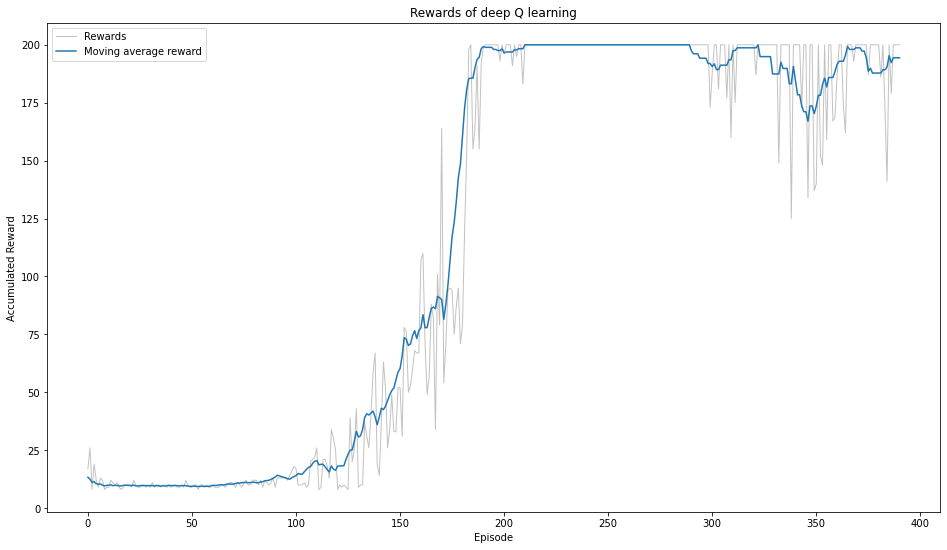

In [13]:
def plot_traning(rewards, n_episodes):
    print(rewards)
    print(len(rewards))
    print(n_episodes)
    averages = moving_average(rewards, 10)
    plt.figure(figsize=(16, 9))
    plt.title('Rewards of deep Q learning')
    plt.plot(range(len(averages)),rewards[:len(averages)], "darkgrey", label="Rewards", linewidth=1, alpha=0.7)
    plt.plot(range(len(averages)),averages, label="Moving average reward")

    plt.ylabel('Accumulated Reward')
    plt.xlabel('Episode')
    plt.legend()
    fname = f'plots/deep_q.png'
    plt.savefig(fname)
    plt.show()


plot_traning(accumlated_rewards, n_episodes)